# Hearthstone Project
***
***

# Goals
- Explore the data to gather insights about the characteristics of the game's different class types

# Purpose
- Practice visualizing data using a wide variety of plot types and configurations

# Setup
***

In [1]:
# establishing environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from acquire import get_hearth
from prepare import prep_hearth

import warnings
warnings.filterwarnings("ignore")

# Acquire
Acquiring data from local csv files
***

In [2]:
# reading in card data and saving as DF
cards = pd.read_csv('hearthstone_standard_cards.csv')

# reading in card classes and saving as DF
classes = pd.read_csv('classes.csv')

# reading in minion types data and saving as DF
mtypes = pd.read_csv('minionTypes.csv')

# reading in rarities data and saving as DF
rarities = pd.read_csv('rarities.csv')

# reading in card sets data and saving as DF
sets = pd.read_csv('sets.csv')

# reading in types data and saving as DF
ctypes = pd.read_csv('types.csv')

# reading in keywords data and saving as DF
keywords = pd.read_csv('keywords.csv')

- Data acquired from local csv files
- Alternatively, the __get_hearth__ function from the __acquire.py__ file can be run to acquire the data
    - The DFs will be returned in the following order by the function: cards, classes, mtypes, rarities, sets, ctypes, keywords

# Prepare
Preparing data for exploration


__IMPORTANT NOTE: Some preparations to the data will be done solely for the purpose of practicing preparation techniques and will not be relevant to the exploration phase.__
***

## Preparing DataFrames for Merge

### Lowercasing column names and values
### Dropping unneeded columns and changing some column names

In [3]:
# lowercasing cards DF columns
cards.columns = cards.columns.str.lower()

# lowercasing name and text column values
cards.text = cards.text.str.lower()
cards.name = cards.name.str.lower()

# creating list of all DFs besides cards
df_list = [classes, mtypes, rarities, sets, ctypes, keywords]

# iterating through DFs
# lowercasing all column names, dropping original name column, renaming slug to name column
for dtafrm in df_list:
        dtafrm.columns = dtafrm.columns.str.lower()
        dtafrm.drop(columns = 'name', inplace = True)
        dtafrm.rename(columns = {"slug": "name"}, inplace = True)       

## Merging DataFrames

### Merging 'classes' DF

In [4]:
# removing brackets and commas from multiclassids column
cards.multiclassids = cards.multiclassids.str.replace('\]|,|\[' , '')

# creating column to hold primary class id 
# if card is of one class, this will reflect its sole class
# if card is dual, this will reflect the 1st of the two classes in the multiClassIds column
# necessary since dual class cards erroneously hold the 'neutral' class value in their primary class id 
cards['primeclassid'] = np.where((cards.multiclassids.str.contains(' ')), cards["multiclassids"].str.split(" ", expand = True)[0], cards.classid)

# converting key columns to make all value data types match
cards.primeclassid = cards.primeclassid.astype(str)
classes.id = classes.id.astype(str)

# merging 'classes' df with card df
df = pd.merge(cards, classes[['id', 'name']], 
              left_on = 'primeclassid', right_on = 'id', how="left", 
              suffixes = (None, '_prime_hero_class'))

# dropping columns I no longer need
df.drop(columns = ['primeclassid', 'classid'], inplace = True)

### Merging 'mtypes' DF

In [5]:
# changing null values of minionTypeId for neutral minions to -1
df['miniontypeid'] = np.where((df.miniontypeid.isnull() == True) & (df.cardtypeid == 4), -1, df.miniontypeid)

# adding missing keyword data to 'keywords' df
# -1 is for minions with no tribe
mtypes.loc[len(mtypes.index)] = ['no_tribe', -1]

# merging 'mtypes' df
df = pd.merge(df, mtypes[['id', 'name']], 
              left_on = 'miniontypeid', right_on = 'id', how="left", 
              suffixes = (None, '_minion_type'))

# dropping column I no longer need
df.drop(columns = ['miniontypeid'], inplace = True)

### Merging 'rarities' DF

In [6]:
# merging 'rarities' df
df = pd.merge(df, rarities[['id', 'name']], 
              left_on = 'rarityid', right_on = 'id', how="left", 
              suffixes = (None, '_rarity'))

# dropping column I no longer need
df.drop(columns = ['rarityid'], inplace = True)

### Merging 'sets' DF

In [7]:
# replacing dashes with underscores in names
sets.name = sets.name.str.replace('-', '_')

# merging 'sets' df
df = pd.merge(df, sets[['id', 'name']], 
              left_on = 'cardsetid', right_on = 'id', how="left", 
              suffixes = (None, '_set'))

# dropping column I no longer need
df.drop(columns = ['cardsetid'], inplace = True)

### Merging 'ctypes' DF

In [8]:
# merging 'ctypes' df
df = pd.merge(df, ctypes[['id', 'name']], 
              left_on = 'cardtypeid', right_on = 'id', how="left", 
              suffixes = (None, '_card_type'))

# dropping column I no longer need
df.drop(columns = ['cardtypeid'], inplace = True)

### Merging 'keywords' DF

In [9]:
# replacing dashes with underscores in names
keywords.name = keywords.name.str.replace('-', '_')

# adding missing keyword data to 'keywords' df
keywords.loc[len(keywords.index)] = ['64', 'start_of_game', 
                                     'does something at the start of the game.', 
                                     'does something at the start of the game.']

# removing brackets and commas from keyword id column
df.keywordids = df.keywordids.str.replace('\]|,|\[' , '')

# splitting keyword ids into separate columns for each card
kwdf = df["keywordids"].str.split(" ", expand = True) 

# renaming columns
kwdf.columns = ['keywordid1', 'keywordid2', 'keywordid3', 'keywordid4', 'keywordid5']

# concatenating split keyword id columns with main df
df = pd.concat([df, kwdf], axis=1)

# converting keywords id column to str type to enable merge
keywords.id = keywords.id.astype(str)

# creating loop to add a column for the text name of each keyword ability of each card
# via merging with keywords DF
for x in kwdf.columns:
    df = pd.merge(df, keywords[['id', 'name']], 
              left_on = x, right_on = 'id', how = "left",
              suffixes = (None, x + '_name'))

## Checking for duplicate rows

In [10]:
# checking number of rows in current DF
df.shape

(1289, 44)

In [11]:
# Checking number of rows if duplicates were dropped
df.drop_duplicates().shape

(1289, 44)

- No duplicates found

### Checking for proper data types, categorical columns (based on domain knowledge), and null counts

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1289 entries, 0 to 1288
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1289 non-null   int64  
 1   collectible            1289 non-null   int64  
 2   slug                   1289 non-null   object 
 3   multiclassids          1289 non-null   object 
 4   artistname             1288 non-null   object 
 5   manacost               1289 non-null   int64  
 6   name                   1289 non-null   object 
 7   text                   1271 non-null   object 
 8   image                  1289 non-null   object 
 9   imagegold              805 non-null    object 
 10  flavortext             1289 non-null   object 
 11  cropimage              1289 non-null   object 
 12  duels                  708 non-null    object 
 13  health                 825 non-null    float64
 14  attack                 860 non-null    float64
 15  keyw

- The following columns will be dropped as they won't be needed for the expected operations of this project
    - id, slug
        - unique identifiers for cards, not needed since the 'name' column provides this while also being easier to reference
    - artistname, image, imagegold, cropimage
        - I won't be exploring images or artist names in this iteration of the project
    - collectible
        - Only 1 value, no nulls, doesn't distinguish any cards
    - all columns reflecting key words with the exception of the boolean columns and the 'slug_keyword#_name' columns
        - The exempted columns are sufficient for the project's expected operations
     
     
- Based on my domain knowledge of the game, I'm inferring that several of the columns are categorical
    - I need to create boolean columns for categorical columns (rarity, card set, etc.)


- Many null values that need to be addressed
    - text
    - duels
    - minion type id
    - health
    - attack
    - child ids
    - durability
    - armor

### Dropping columns that aren't needed for the planned operations of this project

In [13]:
# creating list of columns to drop
columns_to_drop = ['id', 'slug', 'artistname', 'image', 'imagegold', 'flavortext', 'cropimage', 'collectible']

# dropping columns
df.drop(columns = columns_to_drop, inplace = True)

## Addressing Null Values

### Addressing nulls in 'text' column

In [14]:
# checking values in text box
df.text.value_counts(dropna = False)

NaN                                                                                                            18
<b>taunt</b>                                                                                                   15
<b>charge</b>                                                                                                   7
<b>stealth</b>                                                                                                  6
<b>spell damage +1</b>                                                                                          6
                                                                                                               ..
<b>spellburst:</b> summon two 1/3 mana wyrms.                                                                   1
deal 2 damage to a minion. if it's <b>frozen</b>, draw a card.                                                  1
at the start of your turn, restore 3 health to a damaged friendly character.            

In [15]:
# filling null text values with 'no effect'
df["text"].fillna("no effect", inplace = True) 

### Addressing nulls in 'duels' column

In [16]:
# checking duels values
df.duels.value_counts(dropna = False)

{'relevant': True, 'constructed': True}    708
NaN                                        581
Name: duels, dtype: int64

In [17]:
# updating duels column so that cards that were allowed in duels have value of 1 and 0 otherwise
df['duels'] = np.where((df.duels == "{'relevant': True, 'constructed': True}"), 1, 0)

df.rename(columns={'duels':'in_duels'}, inplace=True)

### Addressing nulls in 'id_minion_type', and 'slug_minion_type' columns

In [18]:
# checking minontypeId values
df.id_minion_type.value_counts(dropna = False)

-1.0     497
 NaN     471
 20.0     75
 15.0     63
 18.0     51
 24.0     50
 17.0     32
 14.0     25
 23.0     18
 21.0      6
 26.0      1
Name: id_minion_type, dtype: int64

In [19]:
# converting nulls, aka non-minion cards to 'not a minion' type
df['id_minion_tribe'] = np.where((df.id_minion_type.isnull() == True), 'not a minion', df.id_minion_type)
df['name_minion_tribe'] = np.where((df.name_minion_type.isnull() == True), 'not a minion', df.name_minion_type)

# dropping minionTypeId since id_minion_type suffices
df.drop(columns = ['id_minion_type', 'name_minion_type'], inplace = True)

### Addressing nulls in 'childIds' column

In [20]:
# checking childIds values
df.childids.value_counts(dropna = False)

NaN                                                                       994
[52897, 52900, 53160, 53161, 53162, 53163, 55378, 60588, 64652, 64653]     15
[59723]                                                                     8
[56927]                                                                     3
[53921]                                                                     3
                                                                         ... 
[61651, 61650]                                                              1
[57906]                                                                     1
[59]                                                                        1
[62233]                                                                     1
[55025]                                                                     1
Name: childids, Length: 261, dtype: int64

In [21]:
# filling nulls with "no_childid"
df.childids.fillna("no_childid", inplace = True) 

### Addressing nulls in 'health', 'attack', 'durability', and 'armor' columns
All of these variables respective columns have null values since none of these variables apply to every card (examples: only minions have health while only weapons have durability). For the time being I'll fill these nulls 
with a value that represents infinity. The benefit of this method is that it allows me to fill the nulls while preserving the int64 data type of the column. Furthermore, no matter what value blizzard assigns to these variables in future cards, this value probably wouldn't be used. If this causes issues later I'll employ a different means of handling them. 

In [22]:
# creating list of column names
hada = ['health', 'attack', 'durability', 'armor']

# iterating through columns filling nulls within each
for att in hada:
    df[att].fillna(float('inf'), inplace = True)

## Creating boolean columns for categorical variables

### Creating boolean columns for 'keywords'

In [23]:
# loop iterates through each keyword and creates a boolean column for it
for kw in keywords.name:
    df['has_' + kw] = np.where(
    (df.namekeywordid1_name == kw) |
    (df.namekeywordid2_name == kw) |
    (df.namekeywordid3_name == kw) |
    (df.namekeywordid4_name == kw) |
    (df.namekeywordid5_name == kw), 1, 0)
    
# creating empty list
key_word_col_drop = []

# iterating through columns in df and creating list of columns to drop
for col in df.columns:
    if 'keywordid' in col:
        key_word_col_drop.append(col)
        
# dropping columns
df.drop(columns = key_word_col_drop, inplace = True)

### Creating boolean columns for 'hero classes'

In [24]:
# removing brackets and commas from multiclassids column
df.multiclassids = df.multiclassids.str.replace('\]|,|\[' , '')

# creating column that holds secondary class separate from primary class
df['id_second_hero_class'] = df["multiclassids"].str.split(" ", expand = True)[1]

# converting column to str type to enable merge with newly created column 'id_second_hero_class'
classes.id = classes.id.astype(str)

# creating df containing columns for merge in order to rename before merge without altering original classes DF
classes2 = classes[['id', 'name']]

# renaming columns
classes2.columns = ['id_second_hero_class', 'name_second_hero_class']

# merging 'classes' on secondary hero class id to get secondary class names
df = pd.merge(df, classes2[['id_second_hero_class', 'name_second_hero_class']], 
              on = 'id_second_hero_class', how = "left")

# creating boolean columns for each hero class
for c in classes.name:
    df['is_' + c] = np.where(
    (df.name_prime_hero_class == c) | (df.name_second_hero_class == c), 1, 0)

# filling nulls in new columns
df['name_second_hero_class'].fillna('monoclass', inplace = True)
df['id_second_hero_class'].fillna('monoclass', inplace = True)

### Creating boolean column for multiclass cards

In [25]:
# creating column where 1 = multiclass, 0 = monoclass)
# contains ' ' will suffice since only cards with a space in this value are multiclass
df['is_multiclass'] = np.where((df.multiclassids.str.contains(' ')), 1, 0)

# dropping column I no longer need
df.drop(columns = 'multiclassids', inplace = True)

### Creating boolean column for cards with child ids

In [26]:
# creating column where 1 = card has childids, 0 = card has no childids)
# contains ',' will suffice since only cards with a comma in this value have childids
df['has_child_ids'] = np.where((df.childids.str.contains(',')), 1, 0)

# dropping column I no longer need
df.drop(columns = 'childids', inplace = True)

### Creating boolean columns for rarity levels

In [27]:
# iterating through levels of rarity (common, rare, epic, etc)
# creating boolean column for each
for level in rarities.name:
    df['is_' + level] = np.where((df.name_rarity == level), 1, 0)

### Creating boolean columns for card sets

In [28]:
# iterating through set names and creating a boolean column for each
for setname in sets.name:
    df['is_' + setname] = np.where((df.name_set == setname), 1, 0)

### Creating boolean columns for card type

In [29]:
# iterating through card types and creating a boolean column for each
for ctype in ctypes.name:
    df['is_' + ctype] = np.where((df.name_card_type == ctype), 1, 0)

# dropping column I no longer need
df.drop(columns = 'id_card_type', inplace = True)

### Creating boolean columns for minion tribe

In [30]:
# iterating through minion tribes and creating a boolean column for each
for mtype in mtypes.name:
    df['is_' + mtype] = np.where((df.name_minion_tribe == mtype), 1, 0)

# dropping column I no longer need
df.drop(columns = 'id_minion_tribe', inplace = True)

## Other Preparations

### Dropping boolean columns with all 0 values
I know that some of the sets and keywords that were turned into booleans are not currently in standard (the format the collection of the cards in the data are part of). These columns will be completely filled with 0s so I'm going to drop them.

In [31]:
# creating list of index values for columns that only have 0 values
all_0_cols = np.where(df.isin([0]).all() == True)

# dropping columns based on index value
df.drop(df.columns[all_0_cols], axis = 1, inplace = True)

### Adding rows for dual class cards with prime and secondary class swapped
Adding these rows will make it easier to perform certain operations such as grouping and plotting.

In [32]:
# making identical dfs of all dual class cards
dcc = df[df.name_second_hero_class != 'monoclass']
dcc2 = df[df.name_second_hero_class != 'monoclass']

# swapping primary and secondary hero class values
dcc2.name_prime_hero_class, dcc2.name_second_hero_class, dcc2.id_prime_hero_class, dcc2.id_second_hero_class = dcc.name_second_hero_class, dcc.name_prime_hero_class, dcc.id_second_hero_class, dcc.id_prime_hero_class

# adding new rows to main df
df = pd.concat([df, dcc2])

# resetting index
df.reset_index(drop = True, inplace = True)

### Adding column that holds count of words in card name

In [33]:
# counting words in card names and adding as variable
df['name_word_count'] = df.name.apply(lambda x: len(str(x).split(' ')))

### Adjusting column order

In [34]:
# adjusting order of columns
df = df[['manacost', 'name', 'name_word_count', 'text', 'in_duels', 'has_child_ids', 'health', 'attack',
       'durability', 'armor', 'id_prime_hero_class', 'name_prime_hero_class', 
       'id_second_hero_class', 'name_second_hero_class',
       'id_rarity', 'name_rarity', 'id_set', 'name_set', 'name_card_type',
       'name_minion_tribe', 'has_taunt', 'has_spellpower', 'has_divine_shield',
       'has_charge', 'has_secret', 'has_stealth', 'has_battlecry',
       'has_freeze', 'has_windfury', 'has_deathrattle', 'has_combo',
       'has_overload', 'has_silence', 'has_counter', 'has_immune',
       'has_discover', 'has_quest', 'has_poisonous', 'has_lifesteal',
       'has_rush', 'has_evilzug', 'has_twinspell', 'has_mega_windfury',
       'has_reborn', 'has_empower', 'has_outcast', 'has_spellburst',
       'has_sidequest', 'has_corrupt', 'has_start_of_game',
       'is_demonhunter', 'is_druid', 'is_hunter', 'is_mage', 'is_paladin', 'is_priest',
       'is_rogue', 'is_shaman', 'is_warlock', 'is_warrior', 'is_neutral',
       'is_multiclass', 'is_common', 'is_free', 'is_rare',
       'is_epic', 'is_legendary', 'is_madness_at_the_darkmoon_faire',
       'is_scholomance_academy', 'is_demonhunter_initiate',
       'is_ashes_of_outland', 'is_galakronds_awakening',
       'is_descent_of_dragons', 'is_saviors_of_uldum', 'is_rise_of_shadows',
       'is_classic', 'is_basic', 'is_hero', 'is_minion', 'is_spell',
       'is_weapon', 'is_murloc', 'is_demon', 'is_mech', 'is_elemental',
       'is_beast', 'is_totem', 'is_pirate', 'is_dragon', 'is_all',
       'is_no_tribe']]

# Preparation Phase Summary
- Lowercased all column names and values

- Merged all dataFrames into single dataframe

- Added missing keyword value (start of game)

- Added rows for dual class cards with primary and secondary hero class values swapped

- Changed all dashes in column names to underscores

- Checked for duplicate rows, none found

- Filled nulls with different values based on column and intended operations

- Created boolean columns for categorical values

- Dropped columns that were unuseful for the operations of this project

- Reordered columns

- Alternatively, the __prep_hearth__ function from the __prepare.py__ file can be run (with the 7 separate DFs made from the local csv files as arguments) to prep the data.

# Explore
Exploring the data to identify the characteristics of each class, including neutral

### Establishing dictionary and list of colors for plots

In [35]:
# creating dictionary that holds each class as a key with a color
# can be used to specify the color in plots when dictionary can with plot values can be used
colord = {'rogue' : 'gray', 'shaman' : 'aqua', 'hunter' : 'lime', 'warrior' : 'red', 'priest' : 'white', 
          'paladin' : 'gold', 'mage' : 'cornflowerblue', 'warlock' : 'mediumorchid', 'demonhunter' : 'green',
          'druid' : 'saddlebrown', 'neutral' : 'pink'}

# sorting colorsby corresponding class hero  in alphabetical order
# and creating list from it
# can be used when values are in alphabetical order by class hero
sorted_color_df = pd.DataFrame.from_dict(colord, orient='index').sort_index()
sorted_colors = [i for x in sorted_color_df.values for i in x]

# setting plot figure sizes when size is not specified otherwise
plt.rcParams["figure.figsize"] = (10,7)

### Creating separate DFs for each major card type

In [36]:
minions = df[df.is_minion == 1]
heros = df[df.is_hero == 1]
spells = df[df.is_spell == 1]
weapons = df[df.is_weapon== 1]

### Creating list of class names

In [37]:
classnames = classes.name.to_list()

## Percentage of Minions and Spells within each Class
Since weapons and hero cards make up only a small minority (if any) of the cards within each class, I'm not going to include them in the visualization below.
#### NOTE: I'm aware pie charts are commonly considered bad practice. Since this is a personal projet, I'm making this simply for exhibition purposes.

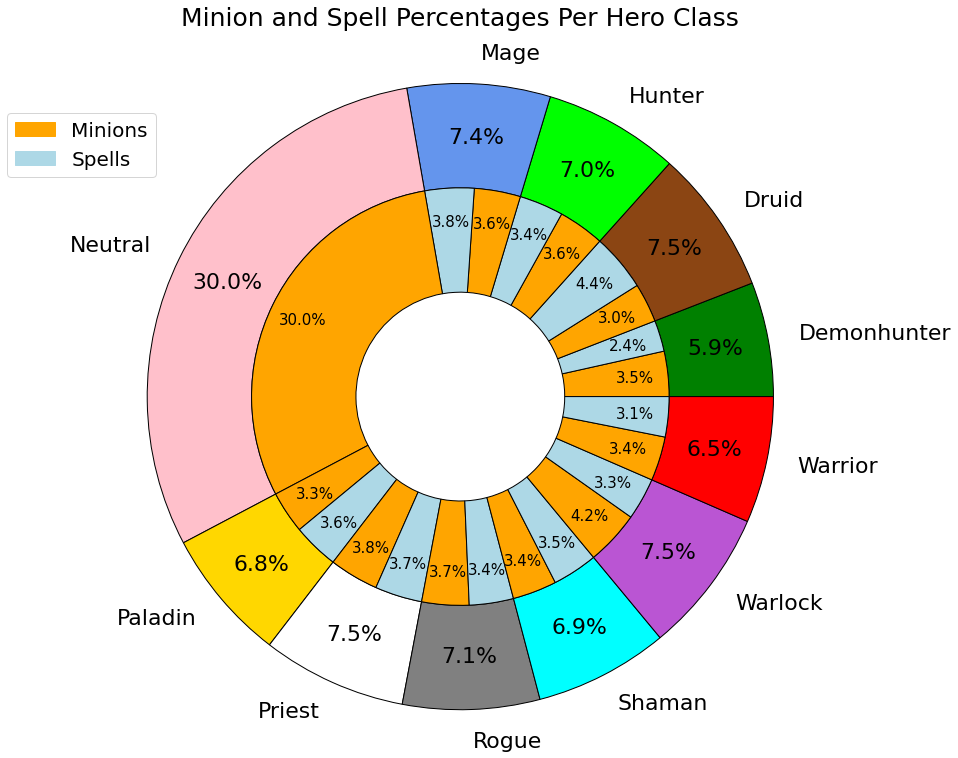

In [72]:
# creating df with all cards except hero cards and weapons
donutplotdf = df[(df.name_card_type != 'hero') & ((df.name_card_type != 'weapon'))]

# creating df of card counts for each hero class
hero_dist_df = pd.DataFrame(donutplotdf.name_prime_hero_class.value_counts().sort_index())
hero_dist_df.columns = ['hero_class_card_count']

# creating df of card counts per card type per hero class
card_type_dist_df = pd.DataFrame(donutplotdf.groupby(['name_prime_hero_class', 'name_card_type']).count()['name'].sort_index(level=['name_prime_hero_class']))

# setting values for outer ring
major_pie_groups = [classname.title() for classname in hero_dist_df.index]
major_group_sizes = [percent for percent in hero_dist_df.hero_class_card_count]

# setting values for inner ring
minor_pie_groups = [x[1] for x in card_type_dist_df.to_dict()['name'].keys()]
minor_group_sizes = [cardtypecount for numlist in card_type_dist_df.values.tolist() for cardtypecount in numlist]

# creating list for minion and spell colors
min_and_spell_colors = [word.replace('minion' ,'orange') for word in minor_pie_groups]
min_and_spell_colors = [word.replace('spell','lightblue') for word in min_and_spell_colors]

# creating outside ring
fig, ax = plt.subplots(figsize=(12,12))
ax.axis('equal')
mypie, _, autotexts = ax.pie(major_group_sizes, radius=1.2, labels = major_pie_groups, autopct='%1.1f%%', pctdistance= .83, colors = sorted_colors, textprops={'fontsize': 22})
plt.setp(mypie, width=0.4, edgecolor='black')

# creating inner ring
mypie2, _, autotexts2 = ax.pie(minor_group_sizes, radius=1.2-0.4, autopct='%1.1f%%', pctdistance= .84, colors = min_and_spell_colors, textprops={'fontsize': 15})
plt.setp( mypie2, width=0.4, edgecolor='black')
plt.margins(0,0)

# creating color list for inner circle
minion_legend_item = mpatches.Patch(color='orange', label='Minions')
spell_legend_item  = mpatches.Patch(color='lightblue', label='Spells')

# creating custom legend
leg = plt.legend(handles=[minion_legend_item, spell_legend_item], prop={"size":20}, bbox_to_anchor=(0.06, .95))

# adding title to plot
plt.title('Minion and Spell Percentages Per Hero Class', fontsize = 25, pad = 45)

# displaying plot 
plt.show()

- The purpose of this visualization was to give an idea of about how the distribution of card types within each class (for example, do mages have a lot more spells than minions? do hunters have mostly minions?, etc)
    - Since I alread know that weapons and hero cards make up only a small minority of all cards, I removed them from the data used in the visualization above since their "slices" within the plot would be too small to offer meaningful insight beyond that they are the minority card types


- Neutral minions account for nearly 1/3 of all cards


- There are no neutral spell cards


- The combined amount of spells and minions within each non-neutral class are relatively close
    - Druid, Priest, and Warlock are tied for the majority at 7.5%
    - Demon Hunter has the lowest amount, making up 5.9% of all minions and spells
    
    
- All non-neutral hero classes have relatively even splits in their ratios of spells to minions

## Average Mana Costs Per Class

In [39]:
# creating df of average mana costs per class
avgmana = pd.DataFrame(df.groupby(['name_prime_hero_class']).mean().sort_values(by = 'manacost', ascending = True)['manacost'])

avgmana

,manacost
name_prime_hero_class,
rogue,3.051546
shaman,3.360825
hunter,3.385417
warrior,3.402062
priest,3.484536
paladin,3.510417
mage,3.614583
warlock,3.680412
demonhunter,3.698795


Text(0, 0.5, 'Hero Class')

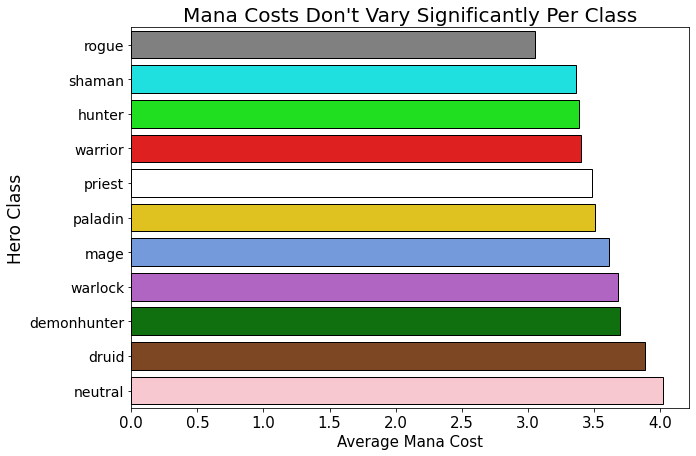

In [40]:
# creating plot
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 14)
plt.title("Mana Costs Don't Vary Significantly Per Class", fontsize = 20)
ax = sns.barplot(x = "manacost", y = avgmana.index, data = avgmana, palette = colord, edgecolor = 'black')
ax.set_xlabel('Average Mana Cost', fontsize = 15)
ax.set_ylabel('Hero Class', fontsize = 17)

- Average mana costs range from ~3 to ~4 mana so there is very little variation 
- However, Rogue does has the lowest average mana cost, ~3
- Neutral has the highest average mana cost, ~4

## Average Mana Costs for Each Class (Per Card Type) 

In [41]:
pd.DataFrame(df.groupby(['name_prime_hero_class', 'name_card_type']).mean()['manacost'])

manacost
name_prime_hero_class name_card_type           
demonhunter           minion           4.133333
                      spell            3.064516
                      weapon           3.714286
druid                 minion           4.948718
                      spell            3.157895
hunter                minion           3.934783
                      spell            2.795455
                      weapon           3.500000
mage                  hero            10.000000
                      minion           3.804348
                      spell            3.306122
neutral               minion           4.028497
                      weapon           1.000000
paladin               minion           4.023810
                      spell            3.021739
                      weapon           3.625000
priest                hero             7.000000
                      minion           3.918367
                      spell            2.957447
rogue                 hero             7.000000
                      minion           3.531915
                      spell            2.386364
                      weapon           3.600000
shaman                hero             7.000000
                      minion           3.954545
                      spell            2.666667
                      weapon           3.571429
warlock               hero             7.000000
                      minion           4.370370
                      spell            2.714286
warrior               hero             7.000000
                      minion           4.136364
                      spell            2.525000
                      weapon           3.333333

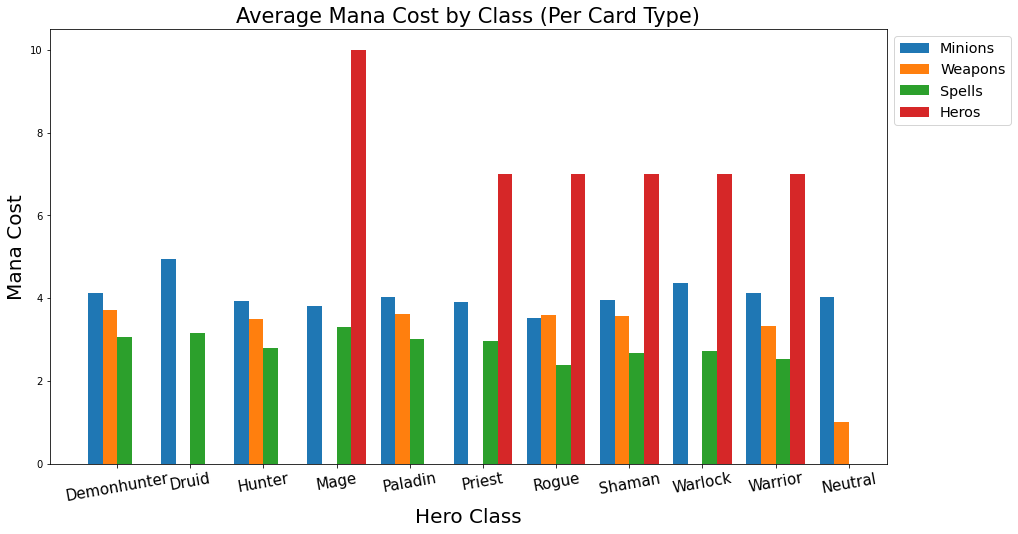

In [42]:
# creating empty dictionaries
minion_mc_dict = {}
weapon_mc_dict = {}
spell_mc_dict = {}
hero_mc_dict = {}

# iterating through class names and storing average manacost for each type of card within each class
for classname in classnames:
    minion_mc = minions[minions.name_prime_hero_class == classname].manacost.mean()
    weapon_mc = weapons[weapons.name_prime_hero_class == classname].manacost.mean()
    spell_mc = spells[spells.name_prime_hero_class == classname].manacost.mean()
    hero_mc = heros[heros.name_prime_hero_class == classname].manacost.mean()
    
    # adding values to dictionary for use in plot
    minion_mc_dict[classname] = minion_mc
    weapon_mc_dict[classname] = weapon_mc
    spell_mc_dict[classname] = spell_mc
    hero_mc_dict[classname] = hero_mc
    
x = np.arange(len(classnames))
width = 0.2 

# creating plots
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(x - width * 1.5, minion_mc_dict.values(), width, label= 'Minions')
ax.bar(x - width * .5, weapon_mc_dict.values(), width, label = 'Weapons')
ax.bar(x + width * .5, spell_mc_dict.values(), width, label= 'Spells')
ax.bar(x + width * 1.5, hero_mc_dict.values(), width, label = 'Heros')

# setting x labels, y labels, xticks, etc.
ax.set_xlabel('Hero Class', fontsize = 20)
ax.set_ylabel('Mana Cost', fontsize = 20)
ax.set_title('Average Mana Cost by Class (Per Card Type)', fontsize = 21)
ax.set_xticks(x)
ax.set_xticklabels([classname.title() for classname in classnames], fontsize = 15, rotation = 10)
ax.legend(bbox_to_anchor=(1, 1), fontsize='x-large')

__General__
- Any bars that are missing from a class means that the class does not have any of that particular type of card
    - For example, mages don't have weapons currently
   
   
__Minions__    
- Druids have the more costly creatures
    - It makes sense that they have more expensive creatures since part of their identity is ramping up resources to play big creatures (and spells)
- Rogues have the cheapest creatures
    - This also makes sense given that part of their identity is being a fast-paced class that plays lots of inexpensive cards


__Weapons__
- The average cost of weapons for each class that has them is very similar with the exception of neutral which has very cheap weapons


__Spells__
- There is a very negligible difference in average spell costs between classes
    - Rogues, have the cheapest spells
        - This is not surprising since again, they are known for have lots of small effect, cheap cards
    - Mages have the most expensive spells
        - This makes sense given that as the name would imply, mages focus on magic and part of their identity is having big, impactful spells, even more so than druid    
        
        
__Heros__
- No hero class has more than 1 hero card and some have non
- Furthermore, every hero class except for Mage share the same hero card, Galakrond, which explains why several have the same mana cost
       

## Average Word Counts in Name per Class

In [43]:
# creating df of average number of words in name per class 
avgnamewc = pd.DataFrame(df.groupby(['name_prime_hero_class']).mean().sort_values(by = 'name_word_count', ascending = True)['name_word_count'])

avgnamewc

,name_word_count
name_prime_hero_class,
rogue,1.845361
warrior,1.896907
shaman,1.907216
hunter,1.947917
demonhunter,1.963855
neutral,1.966408
warlock,1.979381
druid,2.020833
mage,2.072917


Text(0, 0.5, 'Hero Class')

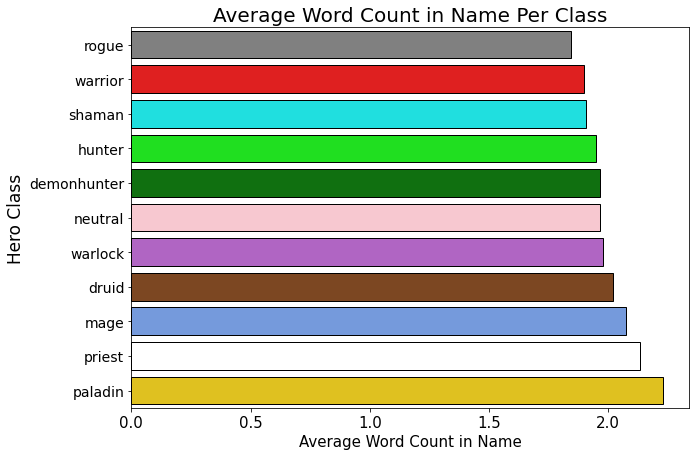

In [44]:
# creating plot
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 14)
plt.title("Average Word Count in Name Per Class", fontsize = 20)
ax = sns.barplot(x = "name_word_count", y = avgnamewc.index, data = avgnamewc, palette = colord, edgecolor = 'black')
ax.set_xlabel('Average Word Count in Name', fontsize = 15)
ax.set_ylabel('Hero Class', fontsize = 17)

- Very little variation in the word counts in the name's of each classes' cards
    - Range is ~1.8 to ~2.3 words
- Rogues have the lowest average words counts
- Paladins have the highest average word counts

## Average Name Word Count by Class (per Card Type)

In [45]:
df.groupby(['name_prime_hero_class', 'name_card_type']).mean()['name_word_count']

name_prime_hero_class  name_card_type
demonhunter            minion            2.000000
                       spell             1.967742
                       weapon            1.714286
druid                  minion            2.076923
                       spell             1.982456
hunter                 minion            1.847826
                       spell             2.068182
                       weapon            1.833333
mage                   hero              3.000000
                       minion            2.086957
                       spell             2.040816
neutral                minion            1.963731
                       weapon            3.000000
paladin                minion            2.142857
                       spell             2.239130
                       weapon            2.625000
priest                 hero              3.000000
                       minion            2.163265
                       spell             2.085106
rogue       

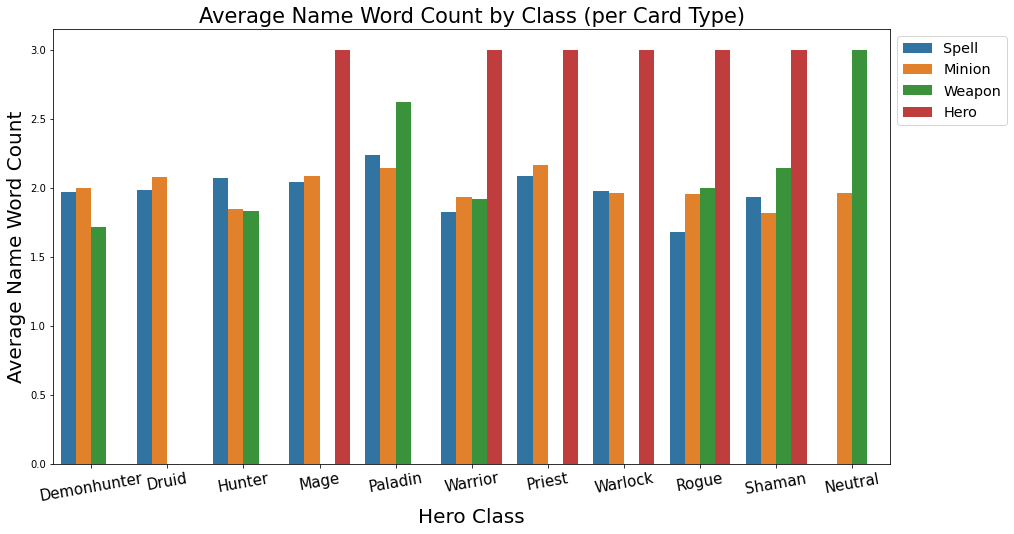

In [46]:
# copying main df to avoid altering
wc_by_ctype_df = df.copy()

# capitalizing hero class names and card types for aesthetic appeal in plot
wc_by_ctype_df.name_prime_hero_class = wc_by_ctype_df.name_prime_hero_class.str.title()
wc_by_ctype_df.name_card_type = wc_by_ctype_df.name_card_type.str.title()

# creating plot
plt.figure(figsize=(15,8))
plt.xticks(fontsize = 15, rotation = 10)
ax = sns.barplot(x = "name_prime_hero_class",  y = "name_word_count", hue = 'name_card_type',  data = wc_by_ctype_df, ci = None)
plt.xlabel('Hero Class', fontsize = 20)
plt.ylabel('Average Name Word Count', fontsize = 20)
plt.title('Average Name Word Count by Class (per Card Type)', fontsize = 21)
ax.legend(bbox_to_anchor=(1, 1), fontsize='x-large')


__General__
- Any bars that are missing from a class means that the class does not have any of that particular type of card
    - For example, druid don't have weapons or hero cards currently
- With the exception of hero cards (covered below), paladin weapons, and neutral weapons, all of the groups of fell into the range of 1.5 to 2.5 average words per name
    - This implies that there is little variance (roughly 1 word) between the average number of words for the cards of each group

- Of all non-neutral classes, paladins have the most words on average for both weapons and spells in addition to nearly being tied for minions
   

__Spells__
- Paladins have the highest word counts in their spell names on average
- Rogues have the lowest word counts in their spell names on average
        
        
__Minions__   
- Priests narrowly beat out paladins for the highest average word count in minion names
- Shamans closely edged out hunters for the lowest average word count in minion names


__Weapons__
- The neutral "class" has the largest highest average word count in weapon names, albeit there is only one neutral weapon currently (Sphere of Sapience)
- With regard to non-neutral classes, paladins have the highest average word count in weapon names
- Demon hunter has the lowest average word count in weapon names

        
__Heros__
- No hero class has more than 1 hero card and some have non
- Furthermore, every hero class except for Mage share the same hero card, Galakrond, which explains why several have the same word count
       

## Variable: Health